1. IMPORTING LIBRARIES

In [174]:
# Importing libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import *
from sklearn.metrics import *
from tensorflow.keras import *
from keras.models import load_model
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

2. LOADING THE DATA

In [175]:
# Loading Training Data
training_dir = 'Training/'
training_paths = []
train_labels = []

for label in os.listdir(training_dir):
    label_dir = os.path.join(training_dir, label)
    if os.path.isdir(label_dir):  # Check if it's a directory
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not file.startswith('.'):  # Exclude hidden files
                training_paths.append(file_path)
                train_labels.append(label)

random.shuffle(training_paths)
random.shuffle(train_labels)

# show an example of the list
print(training_paths[0])

Training/glioma/Tr-gl_0711.jpg


In [176]:
len(training_paths)

5712

In [177]:
# Loading Testing/Validation Data
test_dir = 'Testing/'
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):  # Check if it's a directory
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not file.startswith('.'):  # Exclude hidden files
                test_paths.append(file_path)
                test_labels.append(label)

random.shuffle(test_paths)
random.shuffle(test_labels)

# show an example of the list
print(test_paths[0])

Testing/pituitary/Te-pi_0058.jpg


In [178]:
len(test_paths)

1311

In [198]:
labels = [label for label in os.listdir(training_dir) if not label.startswith('.')]

labels

['pituitary', 'notumor', 'glioma', 'meningioma']

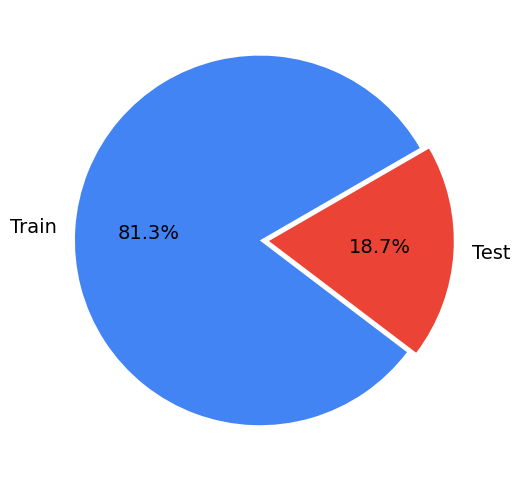

In [180]:
# Ratio of Training Data to Testing Data
plt.figure(figsize=(14,6))
colors = ['#4284f4', '#eb4335']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

3. DATA AUGMENTATION

In [181]:
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(256,256))
        image = image.convert('RGB')
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

def get_labels(paths):
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

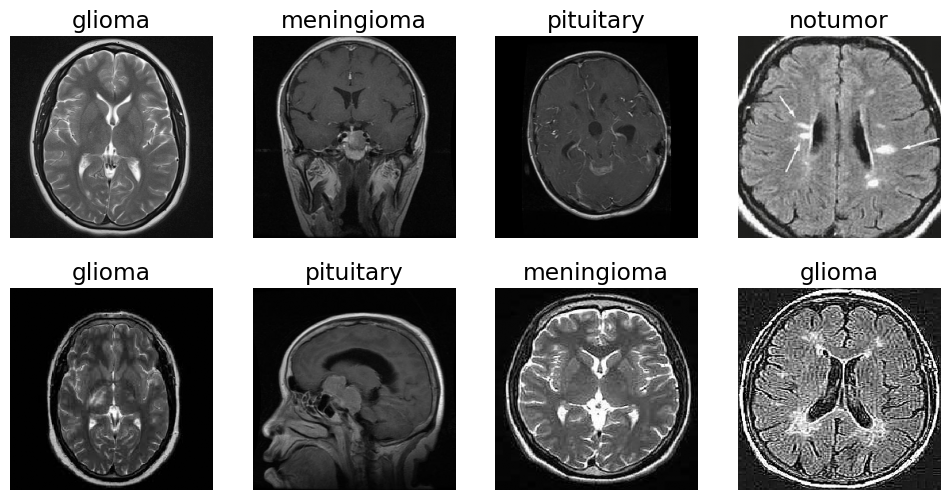

In [182]:
i = random.randint(0,len(training_paths))
images = open_images(training_paths[50:59])
xlabels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(xlabels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 10})
plt.show()

4. DATA GENERATOR

In [183]:
# Expand the size of a training set by creating modified data from existing one
def data_gen(data_paths, batch_size=10):
    '''
    Given the image paths, it yields the images with the respective labels, as a batch
    '''
    for i in range(0, len(data_paths), batch_size):
        paths = data_paths[i:i+batch_size]
        images = open_images(paths)
        labels = get_labels(paths)
        yield images,np.array(labels)

5. BUILDING THE ResNet152V2 MODEL

In [184]:
# Loading the Pre-Trained Model (ResNet152V2)

base_model = ResNet152V2(input_shape = (256,256,3), 
                                                include_top = False, 
                                                weights = 'imagenet' )
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [185]:
len (base_model.layers)

564

In [186]:
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
    
# Set the last ResNet152V2 block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [187]:
model = Sequential()
model.add(Input(shape=(256,256,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # num labels = 4

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_6 (Dropout)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 75109508 (286.52 MB)
Trainable params: 1

6. TRAINING THE MODEL

In [188]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                                loss='sparse_categorical_crossentropy', 
                                metrics=['sparse_categorical_accuracy'])

In [189]:
# Training the Model

batch_size=256

history = model.fit(data_gen(training_paths), 
epochs=20,
steps_per_epoch=int(len(training_paths)/batch_size), 
validation_data= data_gen(test_paths),
validation_steps=int(len(test_paths)/batch_size)
 )

Epoch 1/20


2024-01-29 03:22:18.070697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


22/22 [==============================] - 21s 629ms/step - loss: 2.6989 - sparse_categorical_accuracy: 0.6182 - val_loss: 3.6543 - val_sparse_categorical_accuracy: 0.6200
Epoch 2/20
22/22 [==============================] - 4s 185ms/step - loss: 2.1072 - sparse_categorical_accuracy: 0.7773 - val_loss: 3.7094 - val_sparse_categorical_accuracy: 0.6400
Epoch 3/20
22/22 [==============================] - 4s 186ms/step - loss: 2.2264 - sparse_categorical_accuracy: 0.7955 - val_loss: 1.2930 - val_sparse_categorical_accuracy: 0.7800
Epoch 4/20
22/22 [==============================] - 4s 168ms/step - loss: 2.2253 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.8800
Epoch 5/20
22/22 [==============================] - 4s 164ms/step - loss: 1.3535 - sparse_categorical_accuracy: 0.8000 - val_loss: 1.2400 - val_sparse_categorical_accuracy: 0.8600
Epoch 6/20
22/22 [==============================] - 4s 169ms/step - loss: 0.5975 - sparse_categorical_accuracy

2024-01-29 03:23:44.470503: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11912337048887408533
2024-01-29 03:23:44.470539: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1438712698532530184
2024-01-29 03:23:44.470543: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7311787412423166436
2024-01-29 03:23:44.470575: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1830540887278612326


22/22 [==============================] - 3s 140ms/step - loss: 0.8482 - sparse_categorical_accuracy: 0.8636


7. EVALUATING THE MODEL

In [190]:
evaluation = model.evaluate(data_gen(test_paths))
print('Test Loss:', evaluation[0])
print('Test Accuracy:', evaluation[1])

132/132 [==============================] - 21s 156ms/step - loss: 0.5568 - sparse_categorical_accuracy: 0.8947
Test Loss: 0.5568087697029114
Test Accuracy: 0.8947368264198303


2024-01-29 03:24:05.258341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11912337048887408533


In [197]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted = model.predict(images)[0]
predicted = np.argmax(predicted)
predicted = labels[predicted]
label = test_paths[i].split('/')[-2]
# plt.imshow(images[0])
print('Predicted:', predicted)
print('Actual:', label)

1/1 [==============================] - 0s 115ms/step
Predicted: notumor
Actual: notumor


In [192]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


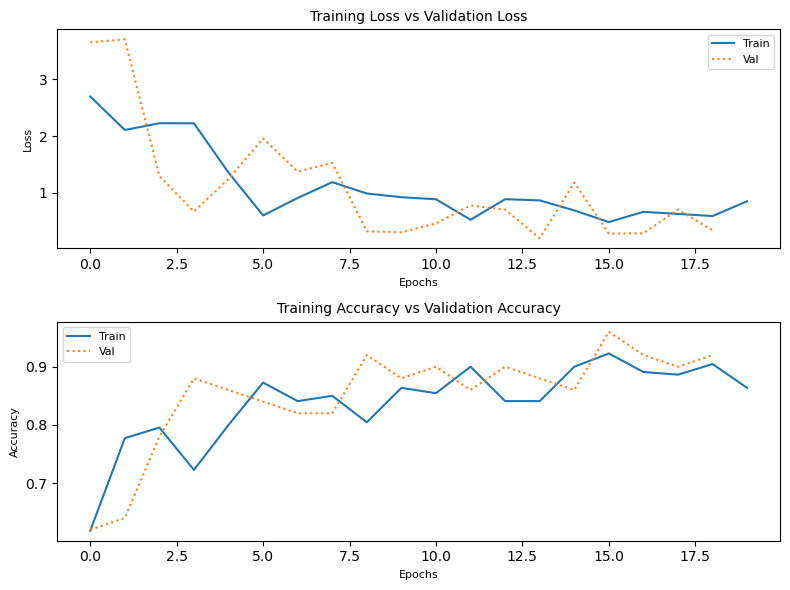

In [193]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Adjust the figure size as needed

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'], linestyle='dotted')
axs[0].set_title('Training Loss vs Validation Loss', fontsize=10)
axs[0].set_xlabel('Epochs', fontsize=8)
axs[0].set_ylabel('Loss', fontsize=8)
axs[0].legend(['Train', 'Val'], fontsize=8)

axs[1].plot(history.history['sparse_categorical_accuracy'])
axs[1].plot(history.history['val_sparse_categorical_accuracy'], linestyle='dotted')
axs[1].set_title('Training Accuracy vs Validation Accuracy', fontsize=10)
axs[1].set_xlabel('Epochs', fontsize=8)
axs[1].set_ylabel('Accuracy', fontsize=8)
axs[1].legend(['Train', 'Val'], fontsize=8)

plt.tight_layout()  
plt.show()


8. CLASSIFICATION REPORT AND CONFUSION MATRIX

In [194]:
# Classification Report
y_pred = model.predict(data_gen(test_paths))
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.array(get_labels(test_paths))

target_names = labels
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=target_names))

132/132 [==============================] - 25s 156ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.83      0.88       300
  meningioma       0.74      0.90      0.81       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.98      0.84      0.90       300

    accuracy                           0.89      1311
   macro avg       0.90      0.89      0.89      1311
weighted avg       0.91      0.89      0.90      1311



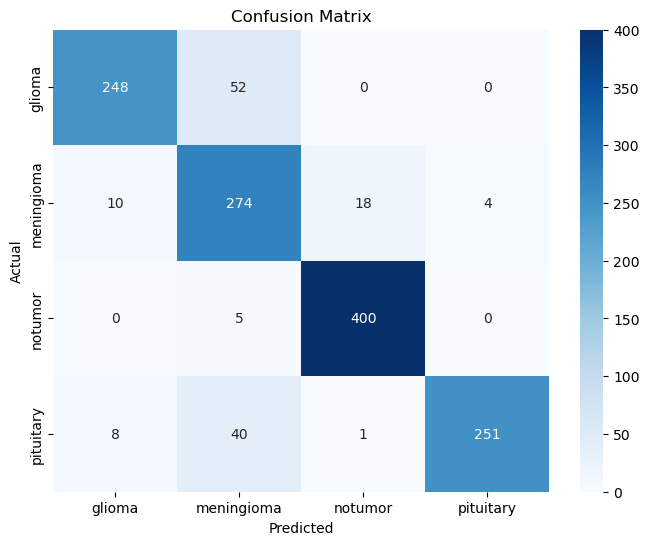

In [195]:
#Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

9. SAVING THE MODEL

In [196]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model
with open('brain.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/qt/hcj8mn3s4rq62dxlffdwnnzw0000gn/T/tmpb4wi5cjh/assets


INFO:tensorflow:Assets written to: /var/folders/qt/hcj8mn3s4rq62dxlffdwnnzw0000gn/T/tmpb4wi5cjh/assets
2024-01-29 03:25:10.898826: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-29 03:25:10.898845: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-29 03:25:10.899105: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/qt/hcj8mn3s4rq62dxlffdwnnzw0000gn/T/tmpb4wi5cjh
2024-01-29 03:25:11.115414: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-29 03:25:11.115436: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/qt/hcj8mn3s4rq62dxlffdwnnzw0000gn/T/tmpb4wi5cjh
2024-01-29 03:25:11.374547: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-29 03:25:13.353096: I tensorflow/cc/saved_model/loader.cc:217] Running initialization